# Predict Spam SMS using Naive Bayes Classifier

## Import Modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.cross_validation import KFold
import matplotlib.pyplot as plt

%matplotlib inline

## Data Preprocessing

We use [SMS Spam Collection Data Set](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection) from UCI, which contains 5574 SMS, 747 of them are spam and the rest are ham.

In [2]:
data = pd.read_csv('./asset/SMSSpamCollection.txt', sep='\t')
pd.set_option("display.max_colwidth",999)
data.head()

,category,text
0,ham,"Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives around here though"


We use the count of each tokens (words) in the SMS as its feature. 

Firstly we convert the SMS into features.

In [3]:
def get_freq_of_tokens(sms):
    tokens = {}
    for token in sms.split(' '):
        if token not in tokens:
            tokens[token] = 1
        else:
            tokens[token] += 1
    return tokens

print(get_freq_of_tokens(data.iloc[0].text))

{'e': 1, 'got': 1, 'bugis': 1, 'great': 1, 'world': 1, 'in': 1, 'Available': 1, 'Go': 1, 'jurong': 1, 'there': 1, 'crazy..': 1, 'buffet...': 1, 'la': 1, 'wat...': 1, 'amore': 1, 'until': 1, 'Cine': 1, 'only': 1, 'n': 1, 'point,': 1}


In [4]:
features_and_labels = []
for index in range(len(data)):
    features_and_labels.append((get_freq_of_tokens(data.iloc[index].text), data.iloc[index].category))

We then trainsform the features into a sparse martix.

In [5]:
encoder = LabelEncoder()
vectorizer = DictVectorizer(dtype=float, sparse=True)
X, y = list(zip(*features_and_labels))
X = vectorizer.fit_transform(X)
    # print(X)
    # print(vectorizer.feature_names_)
y = encoder.fit_transform(y)

X

<5572x15693 sparse matrix of type '<class 'numpy.float64'>'
	with 81504 stored elements in Compressed Sparse Row format>

Use the first SMS (i.e., X[0]) to show how to get the feature names and values. 

In [6]:
arr = X[0].toarray()
for i in range(len(arr[0])):
    if arr[0][i] > 0:
        print('{}:{}'.format(vectorizer.feature_names_[i], arr[0][i]))

Available:1.0
Cine:1.0
Go:1.0
amore:1.0
buffet...:1.0
bugis:1.0
crazy..:1.0
e:1.0
got:1.0
great:1.0
in:1.0
jurong:1.0
la:1.0
n:1.0
only:1.0
point,:1.0
there:1.0
until:1.0
wat...:1.0
world:1.0


## Build Multinomial Naive Bayes Classifier

`alpha` is the additive (Laplace/Lidstone) smoothing parameter. Its default value is 1.0 -- we will see that this works pretty well for our problem later. 

In [7]:
nb = MultinomialNB(alpha=1)
nb.fit(X, y)
nb.score(X, y)

0.99246231155778897

Let's use cross validation to explore how alpha affects the performance of the classifier

In [8]:
n_folds = 10
kf = KFold(n=X.shape[0], n_folds=n_folds, shuffle=True, random_state=42)

In [9]:
def test_Multinomial_NB(train_X, train_y, test_X, test_y, alpha=1, debug = False):
    nb = MultinomialNB(alpha=alpha)
    nb.fit(train_X, train_y)
    train_error = nb.score(train_X, train_y)
    test_error = nb.score(test_X, test_y)
    if debug:
        print('training error:\t{}'.format(train_error))
        print('testing error:\t{}'.format(test_error))
    return train_error, test_error

In [10]:
def cv_MultinomialNB(alpha = 1.0):
    train_error_total = 0
    test_error_total = 0
    for train, test in kf:
        train_X = X[train]
        test_X = X[test]
        train_y = y[train]
        test_y = y[test]
        train_error, test_error = test_Multinomial_NB(train_X, train_y, test_X, test_y, alpha)
        train_error_total += train_error
        test_error_total += test_error
    return train_error_total/n_folds, test_error_total/n_folds
#     print('===================')
#     print('avg. training error:\t{}'.format(train_error_total/n_folds))
#     print('avg. testing error:\t{}'.format(test_error_total/n_folds))

In [11]:
def cv_plot_MultinomialNB():
    cv_res = []
    rng = sorted([0.5] + list(range(0, 10)))
    for i in rng:
        train_error, test_error = cv_MultinomialNB(i)
        cv_res.append([i, train_error, test_error])
    cv_res_arr = np.array(cv_res)
    plt.figure(figsize=(16,9)) 
    plt.title('Error vs. alpha') 
    plot_train, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,1], label='training')
    plot_test, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,2], label='testing')
    plt.legend(handles=[plot_train, plot_test])
    plt.ylim((min(min(cv_res_arr[:,1]), min(cv_res_arr[:,2])) - 0.01, max(max(cv_res_arr[:,1]), max(cv_res_arr[:,2]))+0.01))
    plt.xticks(rng)    

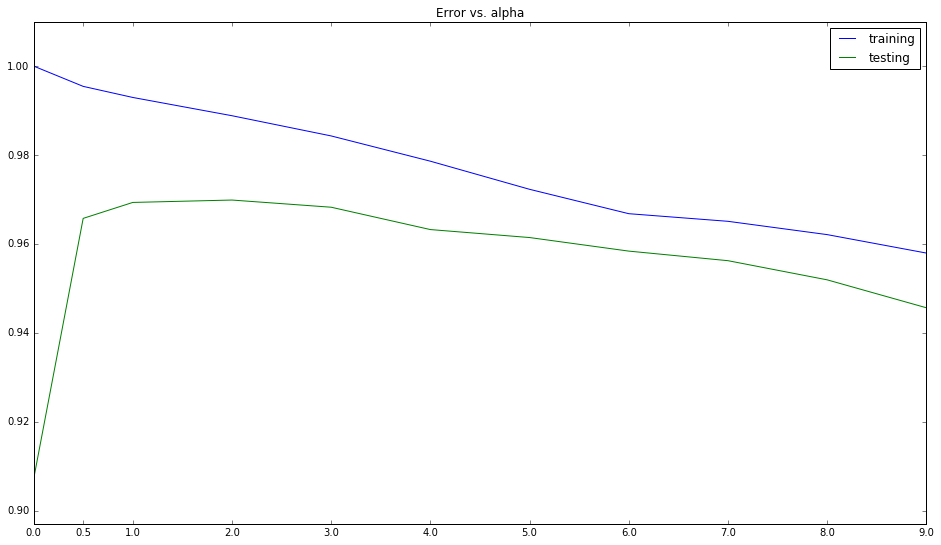

In [12]:
cv_plot_MultinomialNB()

## Bernoulli Naive Bayes Classifier

Note that since we have the count matrix for words in the vocabulary, we can binarize it to be used in a Bernoulli NB classifier. 

In [13]:
nb = BernoulliNB(alpha=1, binarize=0.0) # every value >0.0 will be binarized to 1
nb.fit(X, y)
nb.score(X, y)

0.98438621679827709

In [14]:
def test_Bernoulli_NB(train_X, train_y, test_X, test_y, alpha=1, debug = False):
    nb = BernoulliNB(alpha=alpha)
    nb.fit(train_X, train_y)
    train_error = nb.score(train_X, train_y)
    test_error = nb.score(test_X, test_y)
    if debug:
        print('training error:\t{}'.format(train_error))
        print('testing error:\t{}'.format(test_error))
    return train_error, test_error

In [15]:
def cv_BernoulliNB(alpha = 1.0):
    train_error_total = 0
    test_error_total = 0
    for train, test in kf:
        train_X = X[train]
        test_X = X[test]
        train_y = y[train]
        test_y = y[test]
        train_error, test_error = test_Bernoulli_NB(train_X, train_y, test_X, test_y, alpha)
        train_error_total += train_error
        test_error_total += test_error
    return train_error_total/n_folds, test_error_total/n_folds
#     print('===================')
#     print('avg. training error:\t{}'.format(train_error_total/n_folds))
#     print('avg. testing error:\t{}'.format(test_error_total/n_folds))

In [16]:
def cv_plot_BernoulliNB():
    cv_res = []
    rng = sorted([0.5] + list(range(0, 10)))
    for i in rng:
        train_error, test_error = cv_BernoulliNB(i)
        cv_res.append([i, train_error, test_error])
    cv_res_arr = np.array(cv_res)
    plt.figure(figsize=(16,9)) 
    plt.title('Error vs. alpha')
    plot_train, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,1], label='training')
    plot_test, = plt.plot(cv_res_arr[:,0], cv_res_arr[:,2], label='testing')
    plt.legend(handles=[plot_train, plot_test])
    plt.ylim((min(min(cv_res_arr[:,1]), min(cv_res_arr[:,2])) - 0.01, max(max(cv_res_arr[:,1]), max(cv_res_arr[:,2]))+0.01))
    plt.xticks(rng)

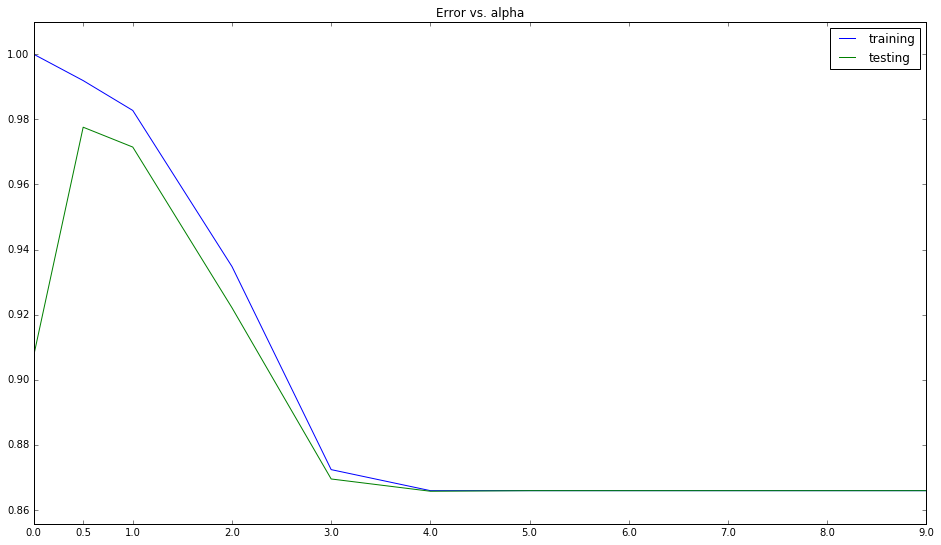

In [17]:
cv_plot_BernoulliNB()